In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyro-ppl

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/path/to/your/utils/directory')
import seaborn as sns
import shap
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score,validation_curve, GridSearchCV, learning_curve
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix,ConfusionMatrixDisplay,classification_report
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from pyro.infer import Predictive
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
thyroid= pd.read_csv('drive/My Drive/Thyroid_Diff.csv')

In [ ]:
X=thyroid.drop(columns=['Recurred'])
y=thyroid['Recurred']

## **Train Test Split**

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=True, random_state=42)

In [ ]:
# Checking class distribution in the training set
print("Class distribution in the training set:")
print(y_train.value_counts())

# Checking class distribution in the test set
print("Class distribution in the test set:")
print(y_test.value_counts())


Class distribution in the training set:
Recurred
0    217
1     89
Name: count, dtype: int64
Class distribution in the test set:
Recurred
0    58
1    19
Name: count, dtype: int64


In [ ]:
!pip install boruta

In [ ]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

# Fit Boruta feature selection
rf = RandomForestClassifier(n_estimators=100, random_state=42)
boruta = BorutaPy(rf, n_estimators='auto', random_state=42)
boruta.fit(X_train.values, y_train.values)

# Get the selected features
selected_boruta_features = X_train.columns[boruta.support_]
print("Selected Features by Boruta:", selected_boruta_features)


In [ ]:
# check ranking of features
boruta.ranking_

array([1, 2, 4, 9, 8, 6, 4, 1, 6, 2, 1, 1, 1, 7, 1, 1])

In [ ]:
# Create a DataFrame for all features
importance_df_all = pd.DataFrame({
    'Feature': features,
    'Importance': ranking
})

# Sort by importance
importance_df_all = importance_df_all.sort_values(by='Importance', ascending=False)

# Plot all features
plt.figure(figsize=(10, len(importance_df_all) * 0.5))  # Adjust height based on number of features
plt.barh(importance_df_all['Feature'], importance_df_all['Importance'], color='orange', label='Not Selected')

# Highlight selected features
selected_features_all = importance_df_all[importance_df_all['Feature'].isin(selected_boruta_features)]
plt.barh(selected_features_all['Feature'], selected_features_all['Importance'], color='green', label='Selected')

plt.xlabel('Importance')
plt.title('Feature Importance (Selected Features Highlighted) by Boruta')
plt.legend()
plt.show()


In [ ]:
# Create new training and test datasets with only selected features
X_train_selected = X_train[selected_boruta_features]
X_test_selected = X_test[selected_boruta_features]

# Check the new training and test data
print("Selected Training Data:")
print(X_train_selected.head())

print("Selected Test Data:")
print(X_test_selected.head())


Selected Training Data:
          Age  Adenopathy  Risk    T    N  Stage  Response
165 -0.057351           3   0.0  2.0  0.0    0.0       0.0
321  1.398184           5   1.0  3.0  2.0    1.0       3.0
220 -0.785118           3   0.0  2.0  1.0    0.0       1.0
94  -0.255833           3   0.0  2.0  0.0    0.0       0.0
232 -0.652797           2   1.0  2.0  2.0    0.0       3.0
Selected Test Data:
          Age  Adenopathy  Risk    T    N  Stage  Response
268 -0.586636           3   0.0  3.0  0.0    0.0       0.0
250 -0.718957           5   0.0  3.0  0.0    0.0       0.0
318 -0.718957           0   1.0  3.0  2.0    0.0       3.0
331  0.670416           3   1.0  3.0  0.0    0.0       3.0
56   0.141131           3   0.0  1.0  0.0    0.0       0.0


In [ ]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)


In [ ]:
X_test=X_test_selected

In [ ]:
# Convert DataFrame to NumPy array first
x_train = torch.tensor(X_train_resampled.values, dtype=torch.float32)
y_train = torch.tensor(y_train_resampled.values, dtype=torch.float32)

In [ ]:
x_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

## **N(0,1), RELU**

In [ ]:
class BNNClassifierNOneRelu(PyroModule):
    def __init__(self, in_dim, hid_dim=5, prior_scale=1.0):
        super().__init__()

        self.activation = nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)
        self.layer2 = PyroModule[nn.Linear](hid_dim, 1)

        # Priors
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([1, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([1]).to_event(1))

    def forward(self, x, y=None):
        x = self.activation(self.layer1(x))
        logits = self.layer2(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)
        return logits


In [ ]:
from pyro.infer import MCMC, NUTS

model1 = BNNClassifierNOneRelu(in_dim=x_train.shape[1])
nuts_kernel1 = NUTS(model1)
mcmc1 = MCMC(nuts_kernel1, num_samples=100, warmup_steps=50)
pyro.set_rng_seed(42)
mcmc1.run(x_train, y_train)


Sample: 100%|██████████| 150/150 [01:41,  1.48it/s, step size=2.67e-02, acc. prob=0.876]


In [ ]:
mean_preds = posterior_preds.mean(axis=0)
epistemic_uncertainty = posterior_preds.std(axis=0)
aleatoric_uncertainty = mean_preds * (1 - mean_preds)




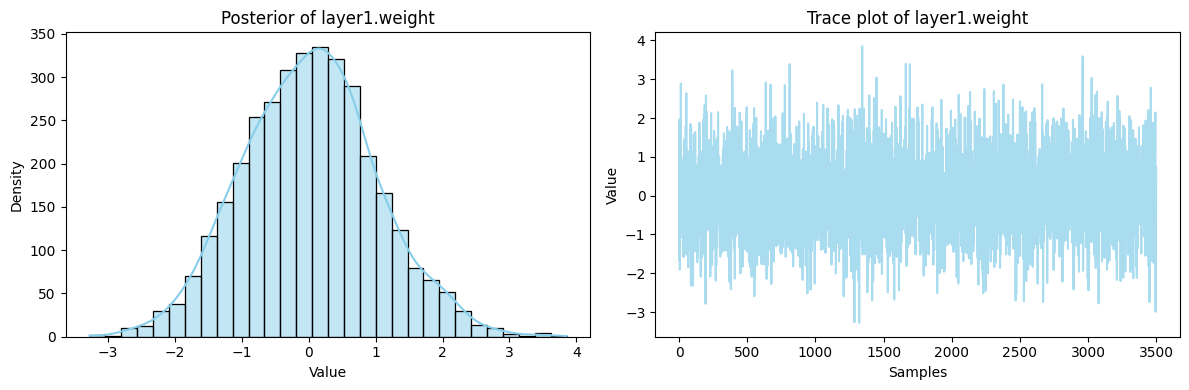

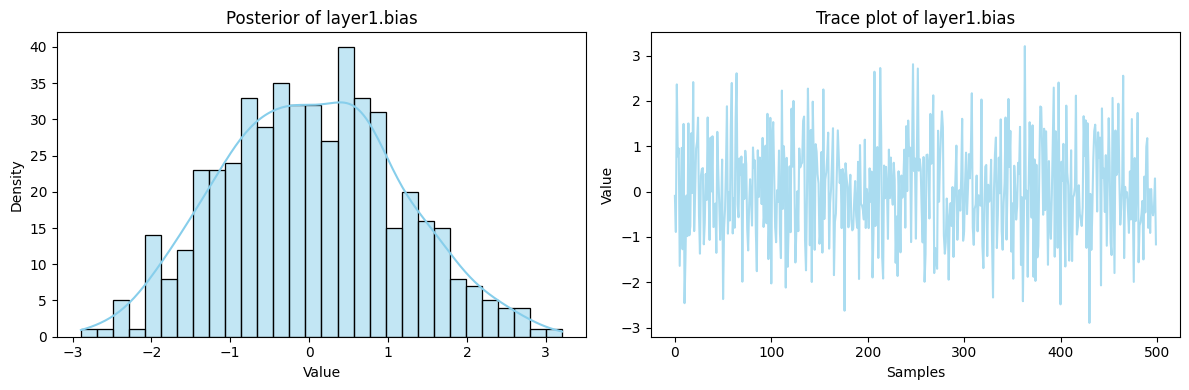

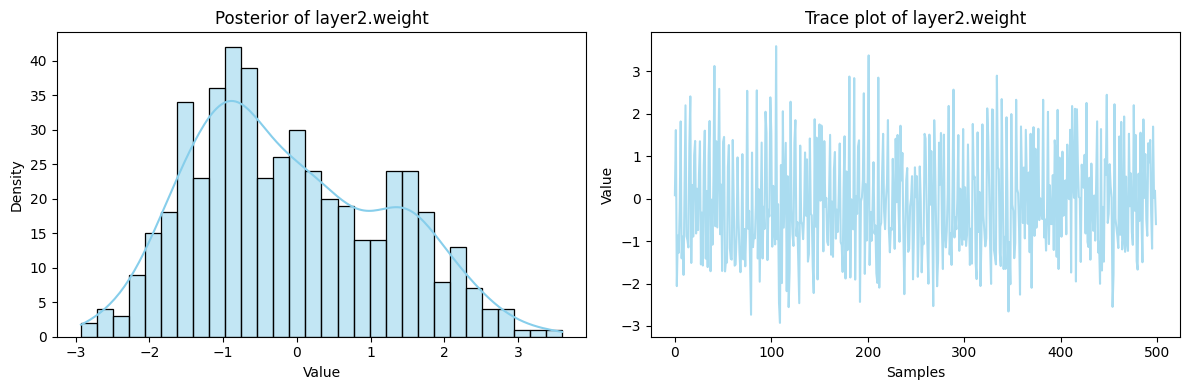

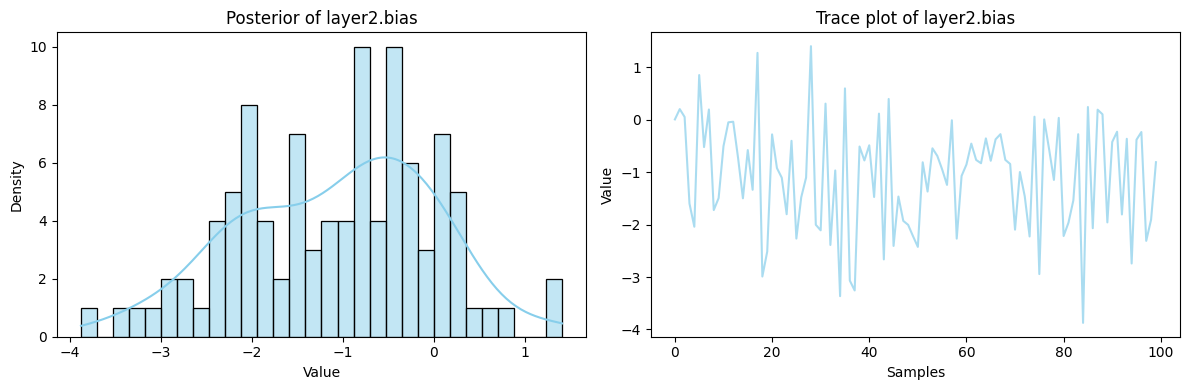

In [ ]:
samples = mcmc1.get_samples()

# Example parameters
param_names = ["layer1.weight", "layer1.bias", "layer2.weight", "layer2.bias"]

for name in param_names:
    plot_trace_and_posterior(name, samples)


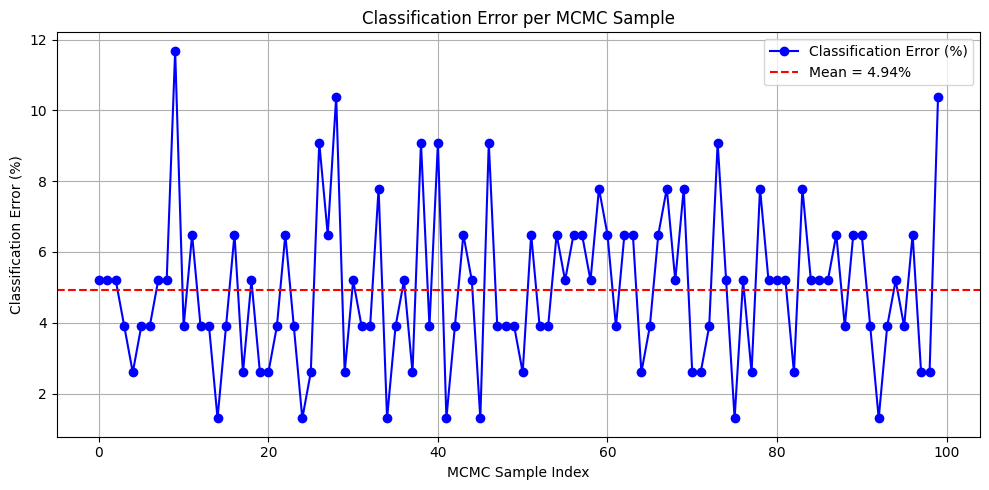

In [ ]:
# Compute classification error per MCMC sample (as percentage)
y_pred_binary_samples = (y_pred_samples > 0.5).astype(int)
classification_errors = (y_pred_binary_samples != y_test.numpy()).mean(axis=1) * 100  # in percentage
sample_indices = np.arange(len(classification_errors))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(sample_indices, classification_errors, marker='o', linestyle='-', color='blue', label='Classification Error (%)')
plt.axhline(classification_errors.mean(), color='red', linestyle='--', label=f"Mean = {classification_errors.mean():.2f}%")

plt.title("Classification Error per MCMC Sample")
plt.xlabel("MCMC Sample Index")
plt.ylabel("Classification Error (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## **N(0,10), RELU**

In [ ]:
class BNNClassifierNTenRelu(PyroModule):
    def __init__(self, in_dim, hid_dim=5, prior_scale=1.0):
        super().__init__()

        self.activation = nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)
        self.layer2 = PyroModule[nn.Linear](hid_dim, 1)

        # Priors
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([1, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([1]).to_event(1))

    def forward(self, x, y=None):
        x = self.activation(self.layer1(x))
        logits = self.layer2(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)
        return logits


In [ ]:
from pyro.infer import MCMC, NUTS

model2 = BNNClassifierNTenRelu(in_dim=x_train.shape[1])
nuts_kernel2 = NUTS(model2)
mcmc2 = MCMC(nuts_kernel2, num_samples=100, warmup_steps=50)
pyro.set_rng_seed(42)
mcmc2.run(x_train, y_train)


Sample: 100%|██████████| 150/150 [01:54,  1.31it/s, step size=2.43e-02, acc. prob=0.821]


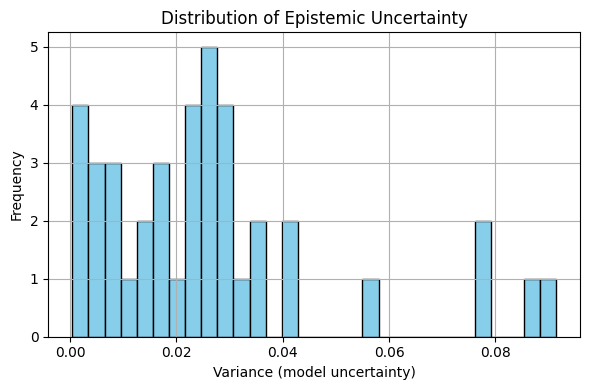

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(epistemic.numpy(), bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Epistemic Uncertainty")
plt.xlabel("Variance (model uncertainty)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

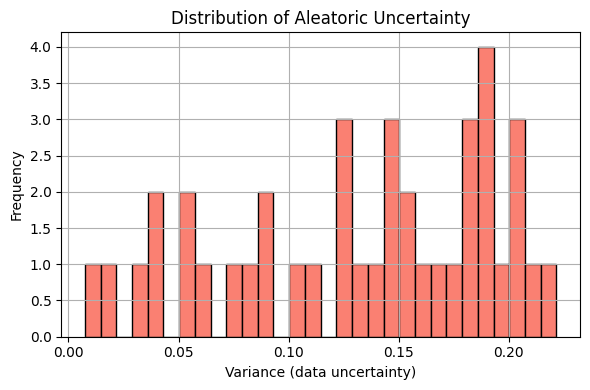

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(aleatoric.numpy(), bins=30, color='salmon', edgecolor='black')
plt.title("Distribution of Aleatoric Uncertainty")
plt.xlabel("Variance (data uncertainty)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import torch
import shap

# Extract posterior samples (e.g., mean weights)
posterior_samples = mcmc2.get_samples()

# Calculate mean parameter values from posterior
layer1_weight_mean = posterior_samples['layer1.weight'].mean(dim=0)
layer1_bias_mean = posterior_samples['layer1.bias'].mean(dim=0)
layer2_weight_mean = posterior_samples['layer2.weight'].mean(dim=0)
layer2_bias_mean = posterior_samples['layer2.bias'].mean(dim=0)

# Define a deterministic prediction function using these means
def bnn_predict(x):
    # Convert input numpy array to torch tensor
    x_tensor = torch.tensor(x, dtype=torch.float32)

    # Forward pass using mean weights and biases
    hidden = torch.relu(torch.matmul(x_tensor, layer1_weight_mean.T) + layer1_bias_mean)
    logits = torch.matmul(hidden, layer2_weight_mean.T) + layer2_bias_mean
    probs = torch.sigmoid(logits).squeeze(-1)
    predicted = (probs > 0.5).int()
    # Convert output back to numpy array for SHAP
    return probs.detach().numpy()



In [ ]:
feature_names = ['Age', 'Adenopathy', 'Risk', 'T', 'N', 'Stage', 'Response']


  0%|          | 0/77 [00:00<?, ?it/s]

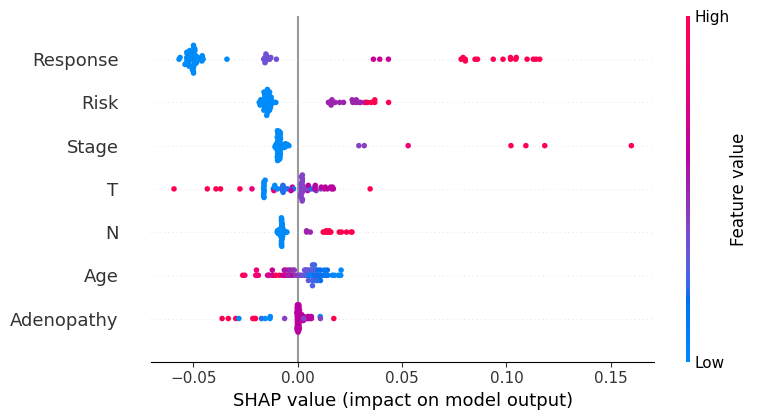

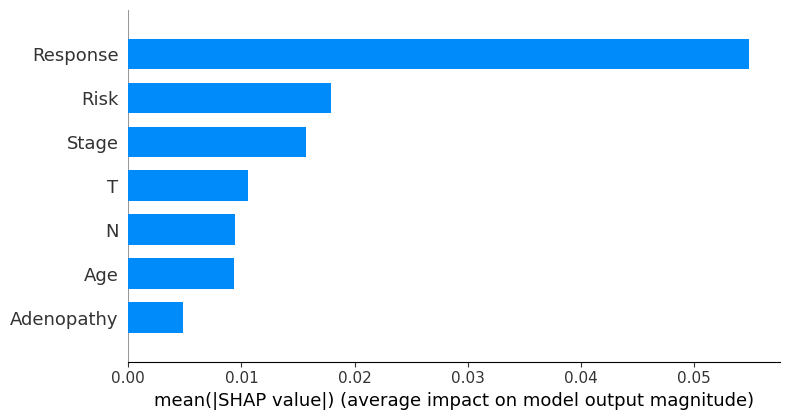

In [ ]:
# Convert your train and test sets to numpy arrays (if not already)
x_train_np = x_train.detach().numpy()
x_test_np = x_test.detach().numpy()

# Your feature names list (make sure order matches features in x_train/x_test)
feature_names = ['Age', 'Adenopathy', 'Risk', 'T', 'N', 'Stage', 'Response']

# Use a small subset of train data as background for KernelExplainer
background = x_train_np[:100]

# Define SHAP explainer with the background dataset
explainer = shap.KernelExplainer(bnn_predict, background)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(x_test_np)

# Plot SHAP summary plot (dot plot) for test set
shap.summary_plot(shap_values, x_test_np, feature_names=feature_names)

# Optional: plot SHAP bar plot for test set
shap.summary_plot(shap_values, x_test_np, feature_names=feature_names, plot_type="bar")


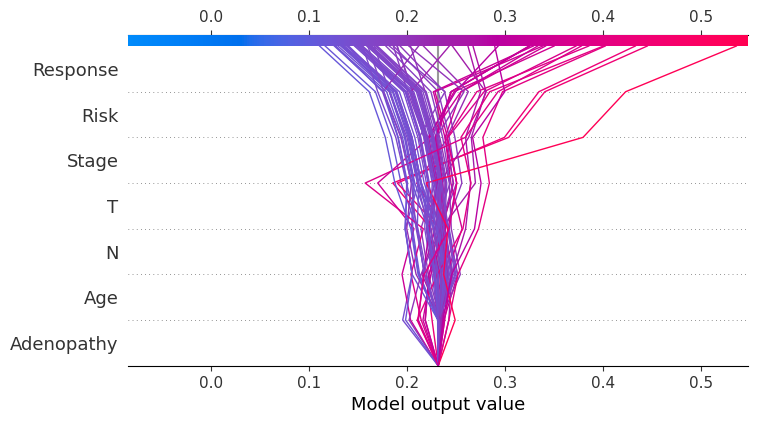

In [ ]:
shap.decision_plot(explainer.expected_value, shap_values, x_test_np, feature_names=feature_names, )

In [ ]:
def bnn_predict_class(x):
    x_tensor = torch.tensor(x, dtype=torch.float32)

    hidden = torch.relu(torch.matmul(x_tensor, layer1_weight_mean.T) + layer1_bias_mean)
    logits = torch.matmul(hidden, layer2_weight_mean.T) + layer2_bias_mean
    probs = torch.sigmoid(logits).squeeze(-1)

    predicted = (probs > 0.5).int()  # Binary class threshold
    return predicted.numpy()


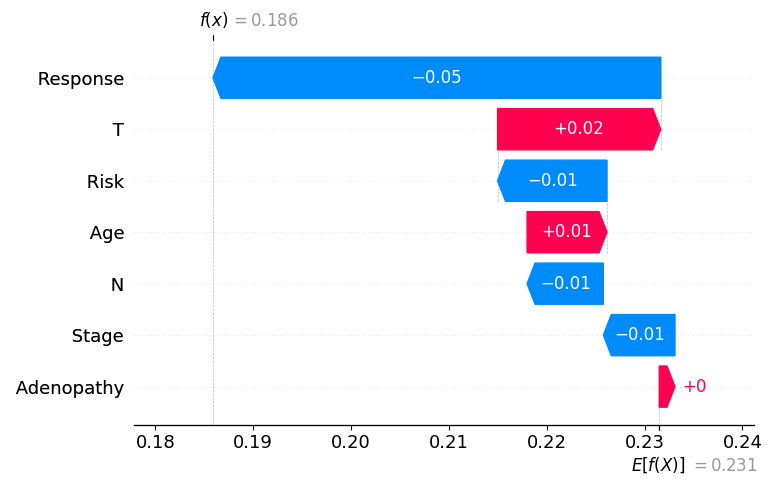

Waterfall plot for predicted class 0


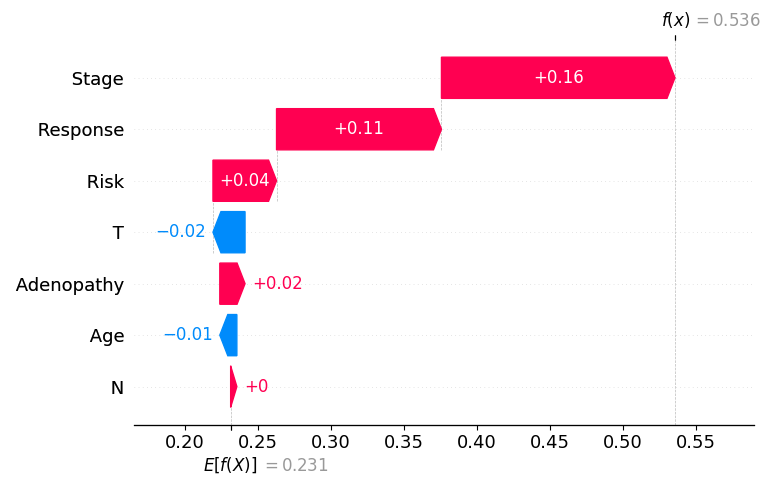

Waterfall plot for predicted class 1


In [ ]:
# Get predicted labels for X_explain
predicted_labels = bnn_predict_class(x_test_np)



import shap

for label in set(predicted_labels):
    idx = (predicted_labels == label).argmax()

    shap.plots._waterfall.waterfall_legacy(
        explainer.expected_value,
        shap_values[idx],
        x_test_np[idx],
        feature_names=feature_names
    )

    print(f"Waterfall plot for predicted class {label}")


In [ ]:
posterior_samples = mcmc2.get_samples()
print(posterior_samples.keys())  # List parameter names


dict_keys(['layer1.bias', 'layer1.weight', 'layer2.bias', 'layer2.weight'])


In [ ]:
mean_preds = posterior_preds.mean(axis=0)
epistemic_uncertainty = posterior_preds.std(axis=0)
aleatoric_uncertainty = mean_preds * (1 - mean_preds)




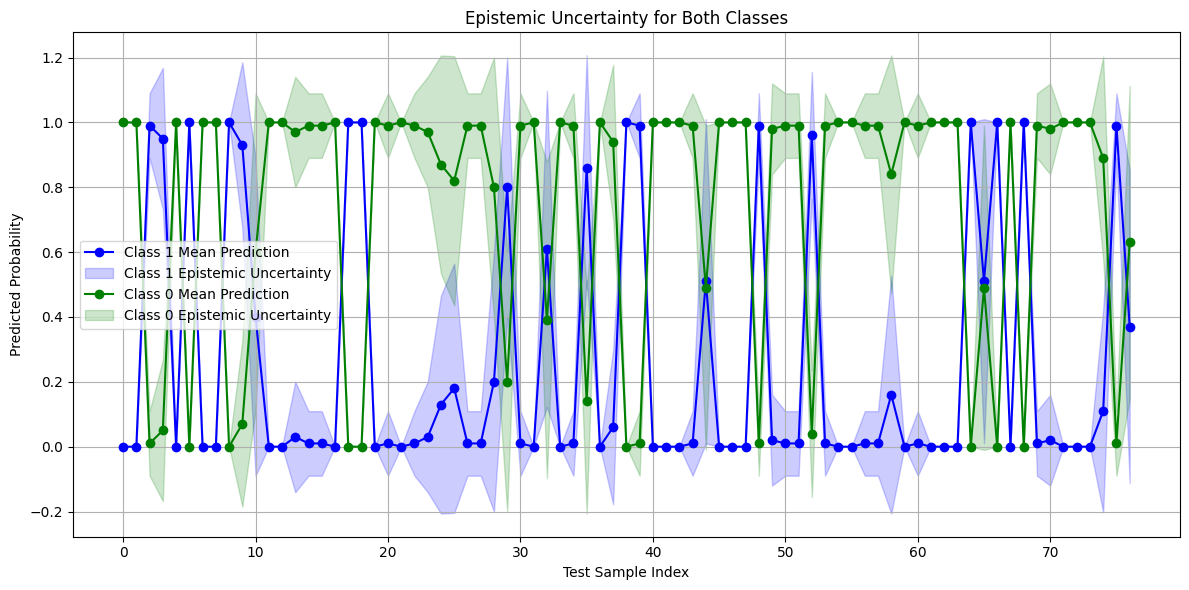

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming these are already computed
# posterior_preds: [n_samples, N_test]
class1_preds = posterior_preds
class0_preds = 1 - posterior_preds

# Predictive means and epistemic uncertainties
class1_mean = class1_preds.mean(axis=0)
class0_mean = class0_preds.mean(axis=0)
class1_epistemic = class1_preds.std(axis=0)
class0_epistemic = class0_preds.std(axis=0)

x = np.arange(len(class1_mean))

plt.figure(figsize=(12, 6))

# Class 1
plt.plot(x, class1_mean, 'o-', color='blue', label='Class 1 Mean Prediction')
plt.fill_between(x,
                 class1_mean - class1_epistemic,
                 class1_mean + class1_epistemic,
                 color='blue', alpha=0.2, label='Class 1 Epistemic Uncertainty')

# Class 0
plt.plot(x, class0_mean, 'o-', color='green', label='Class 0 Mean Prediction')
plt.fill_between(x,
                 class0_mean - class0_epistemic,
                 class0_mean + class0_epistemic,
                 color='green', alpha=0.2, label='Class 0 Epistemic Uncertainty')

plt.title("Epistemic Uncertainty for Both Classes")
plt.xlabel("Test Sample Index")
plt.ylabel("Predicted Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Predictive mean
pred_mean = np.mean(posterior_preds, axis=0)

# Aleatoric uncertainty: expected variance of Bernoulli at each sample
aleatoric_unc = np.mean(posterior_preds * (1 - posterior_preds), axis=0)

# Epistemic uncertainty: variance of predicted probabilities
epistemic_unc = np.var(posterior_preds, axis=0)

# Total uncertainty (optional)
total_unc = aleatoric_unc + epistemic_unc



In [ ]:
posterior_preds

array([[0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 0., 1., 1.],
       ...,
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 1.]], dtype=float32)

In [ ]:
aleatoric_unc

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
from pyro.infer import Predictive

# Use all posterior samples to form predictive distribution
predictive = Predictive(model2, posterior_samples=mcmc2.get_samples(), return_sites=["obs", "_RETURN"])
predictive

Predictive(
  (model): BNNClassifierNTenRelu(
    (activation): ReLU()
    (layer1): PyroLinear(in_features=7, out_features=5, bias=True)
    (layer2): PyroLinear(in_features=5, out_features=1, bias=True)
  )
)

In [ ]:
import torch

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
num_samples = 100  # number of posterior predictive samples

# Get predictive samples
samples = predictive(x_test_tensor)
logits_samples = samples["_RETURN"]  # shape: [num_samples, N_test]

# Convert logits to probabilities (using sigmoid since you're doing binary classification)
posterior_probs = torch.sigmoid(logits_samples).detach().numpy()
# Shape: [num_samples, N_test]


/tmp/ipython-input-64-224662338.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


In [ ]:
posterior_probs

array([[8.5526437e-04, 5.6742581e-05, 9.8172116e-01, ..., 1.2697175e-01,
        9.9909019e-01, 2.7182055e-01],
       [4.0225163e-03, 4.4313839e-04, 9.9749076e-01, ..., 8.4755525e-02,
        9.9865711e-01, 7.0896834e-01],
       [1.0319311e-03, 3.5446289e-04, 9.9555737e-01, ..., 7.6037750e-02,
        9.9975091e-01, 3.7514570e-01],
       ...,
       [1.8901287e-03, 4.9178419e-04, 9.9958128e-01, ..., 1.1527345e-01,
        9.9994588e-01, 1.7597277e-01],
       [7.1147399e-04, 9.0248196e-04, 9.9665630e-01, ..., 1.4310008e-02,
        9.9853718e-01, 4.0246561e-02],
       [2.0789090e-03, 1.9788662e-04, 9.9264902e-01, ..., 8.3084136e-02,
        9.9965167e-01, 6.1855626e-01]], dtype=float32)

In [ ]:
# Predictive mean
pred_mean = np.mean(posterior_probs, axis=0)

# Epistemic uncertainty: model uncertainty
epistemic_unc = np.var(posterior_probs, axis=0)

# Aleatoric uncertainty: expected variance of Bernoulli distribution
aleatoric_unc = np.mean(posterior_probs * (1 - posterior_probs), axis=0)


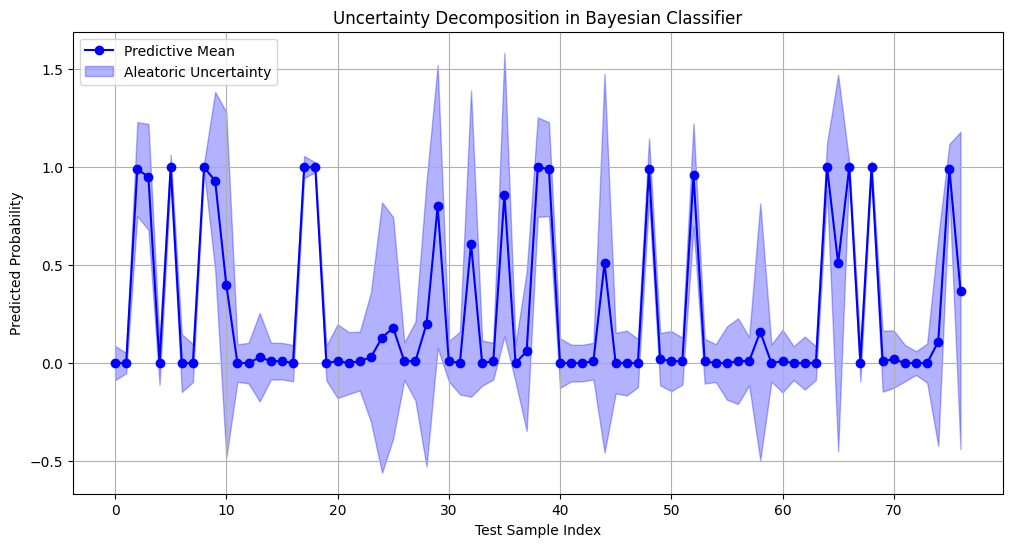

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(len(pred_mean))

plt.figure(figsize=(12, 6))
plt.plot(x, pred_mean, 'o-', label='Predictive Mean', color='blue')
plt.fill_between(x, pred_mean - 2*np.sqrt(aleatoric_unc), pred_mean + 2*np.sqrt(aleatoric_unc),
                 color='blue', alpha=0.3, label='Aleatoric Uncertainty')
#plt.fill_between(x, pred_mean - 2*np.sqrt(epistemic_unc), pred_mean + 2*np.sqrt(epistemic_unc),
                 #color='red', alpha=0.2, label='Epistemic Uncertainty')
plt.legend()
plt.title("Uncertainty Decomposition in Bayesian Classifier")
plt.xlabel("Test Sample Index")
plt.ylabel("Predicted Probability")
plt.grid(True)
plt.show()


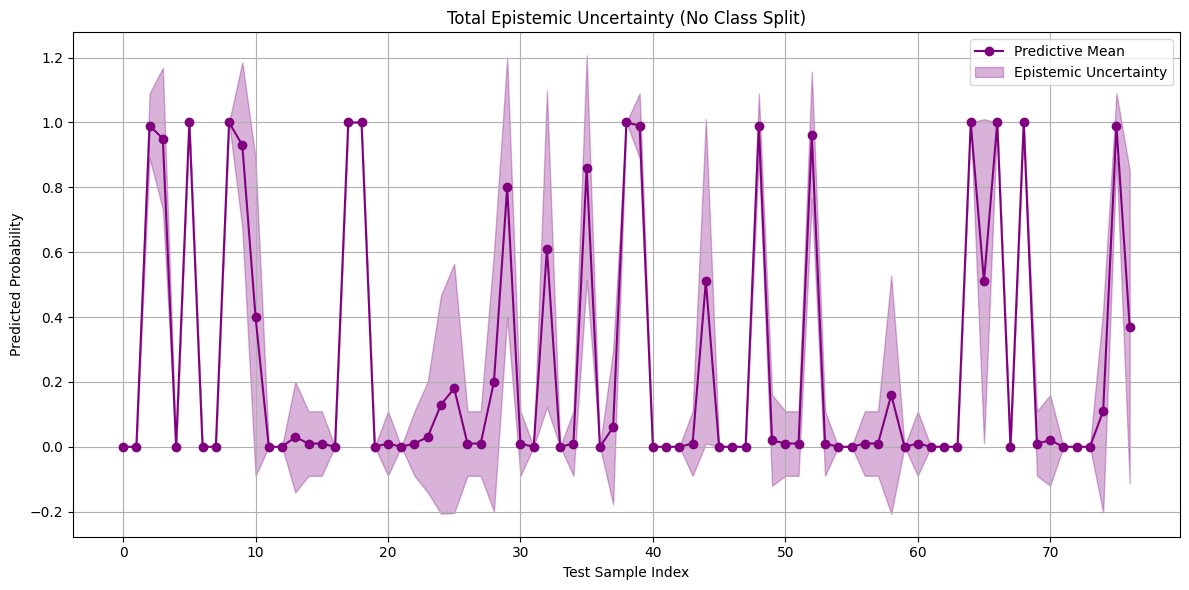

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Assume posterior_preds is already defined ---
# Shape: [n_samples, N_test], values in [0, 1]
# For example:
# posterior_preds = np.random.rand(100, 80)  # mock-up if you want to test

# Step 1: Predictive mean
pred_mean = posterior_preds.mean(axis=0)  # Shape: [N_test]

# Step 2: Epistemic uncertainty (standard deviation across posterior samples)
epistemic_unc = posterior_preds.std(axis=0)  # Shape: [N_test]

# Step 3: X-axis for plotting
x = np.arange(len(pred_mean))

# Step 4: Plot
plt.figure(figsize=(12, 6))

# Mean prediction line
plt.plot(x, pred_mean, 'o-', color='purple', label='Predictive Mean')

# Epistemic uncertainty band (±1σ)
plt.fill_between(x,
                 pred_mean - epistemic_unc,
                 pred_mean + epistemic_unc,
                 color='purple', alpha=0.3, label='Epistemic Uncertainty')

# Optional: for ±2σ instead of ±1σ, uncomment this line and comment the one above
# plt.fill_between(x, pred_mean - 2*epistemic_unc, pred_mean + 2*epistemic_unc, color='purple', alpha=0.2, label='Epistemic Uncertainty (±2σ)')

plt.title("Total Epistemic Uncertainty (No Class Split)")
plt.xlabel("Test Sample Index")
plt.ylabel("Predicted Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print(samples.keys())

dict_keys(['layer1.bias', 'layer1.weight', 'layer2.bias', 'layer2.weight'])


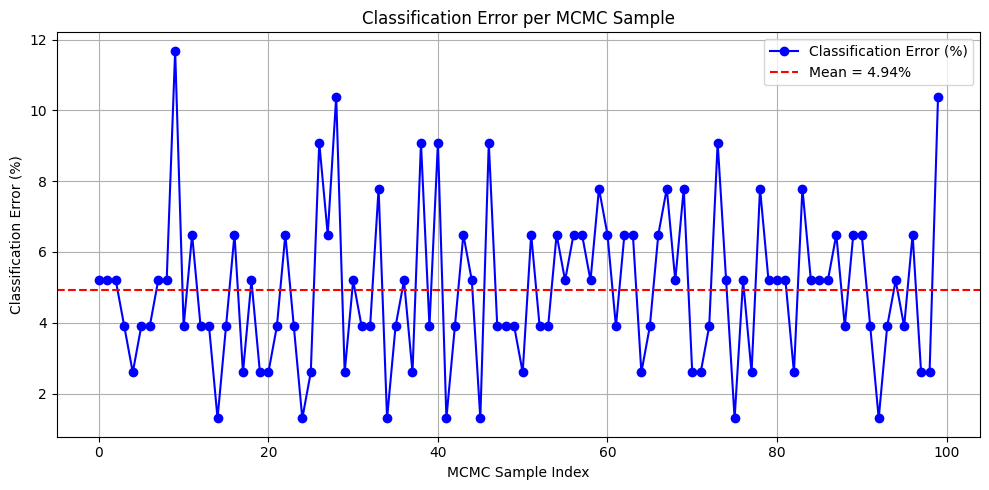

In [ ]:
# Compute classification error per MCMC sample (as percentage)
y_pred_binary_samples = (y_pred_samples > 0.5).astype(int)
classification_errors = (y_pred_binary_samples != y_test.numpy()).mean(axis=1) * 100  # in percentage
sample_indices = np.arange(len(classification_errors))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(sample_indices, classification_errors, marker='o', linestyle='-', color='blue', label='Classification Error (%)')
plt.axhline(classification_errors.mean(), color='red', linestyle='--', label=f"Mean = {classification_errors.mean():.2f}%")

plt.title("Classification Error per MCMC Sample")
plt.xlabel("MCMC Sample Index")
plt.ylabel("Classification Error (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## **Laplace(0,1), ReLU**

In [ ]:
from pyro.distributions import Laplace

In [ ]:
class BNNLaplaceClassifier(PyroModule):
    def __init__(self, in_dim, hid_dim=5, prior_scale=1.0):
        super().__init__()

        self.activation = nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)
        self.layer2 = PyroModule[nn.Linear](hid_dim, 1)

        # Priors
        self.layer1.weight = PyroSample(Laplace(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(Laplace(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(Laplace(0., prior_scale).expand([1, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(Laplace(0., prior_scale).expand([1]).to_event(1))

    def forward(self, x, y=None):
        x = self.activation(self.layer1(x))
        logits = self.layer2(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)
        return logits


In [ ]:
from pyro.infer import MCMC, NUTS

model3 = BNNLaplaceClassifier(in_dim=x_train.shape[1])
nuts_kernel3 = NUTS(model3)
mcmc3 = MCMC(nuts_kernel3, num_samples=100, warmup_steps=50)
pyro.set_rng_seed(42)
mcmc3.run(x_train, y_train)


Sample: 100%|██████████| 150/150 [02:08,  1.17it/s, step size=2.91e-02, acc. prob=0.587]



## **Cauchy(0,1), ReLU**

In [ ]:
class BNNClassifierCauchyRelu(PyroModule):
    def __init__(self, in_dim, hid_dim=5, prior_scale=1.0):
        super().__init__()

        self.activation = nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)
        self.layer2 = PyroModule[nn.Linear](hid_dim, 1)

        # Priors
        # Cauchy Priors
        self.layer1.weight = PyroSample(dist.Cauchy(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Cauchy(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Cauchy(0., prior_scale).expand([1, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Cauchy(0., prior_scale).expand([1]).to_event(1))

    def forward(self, x, y=None):
        x = self.activation(self.layer1(x))
        logits = self.layer2(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)
        return logits


In [ ]:
from pyro.infer import MCMC, NUTS

model4 = BNNClassifierCauchyRelu(in_dim=x_train.shape[1])
nuts_kernel4 = NUTS(model4)
mcmc4 = MCMC(nuts_kernel4, num_samples=100, warmup_steps=50)
pyro.set_rng_seed(42)
mcmc4.run(x_train, y_train)


Sample: 100%|██████████| 150/150 [08:02,  3.22s/it, step size=7.33e-03, acc. prob=0.871]



## **Cauchy(0,2.5), ReLU**

In [ ]:
class BNNClassifierCauchyTwoRelu(PyroModule):
    def __init__(self, in_dim, hid_dim=5, prior_scale=2.5):
        super().__init__()

        self.activation = nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)
        self.layer2 = PyroModule[nn.Linear](hid_dim, 1)

        # Priors
        # Cauchy Priors
        self.layer1.weight = PyroSample(dist.Cauchy(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Cauchy(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Cauchy(0., prior_scale).expand([1, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Cauchy(0., prior_scale).expand([1]).to_event(1))

    def forward(self, x, y=None):
        x = self.activation(self.layer1(x))
        logits = self.layer2(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)
        return logits


In [ ]:
from pyro.infer import MCMC, NUTS

model5 = BNNClassifierCauchyTwoRelu(in_dim=x_train.shape[1])
nuts_kernel5 = NUTS(model5)
mcmc5 = MCMC(nuts_kernel5, num_samples=100, warmup_steps=50)
pyro.set_rng_seed(42)
mcmc5.run(x_train, y_train)


Sample: 100%|██████████| 150/150 [08:04,  3.23s/it, step size=4.60e-03, acc. prob=0.706]


## **Horshoe, Relu**

In [ ]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

class BNNClassifierHorseshoeReLU(PyroModule):
    def __init__(self, in_dim, hid_dim=5, tau_0=1.0):
        super().__init__()
        self.activation = nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)
        self.layer2 = PyroModule[nn.Linear](hid_dim, 1)

        # Set priors using closure over tau_0
        self.layer1.weight = PyroSample(self.horseshoe_prior([hid_dim, in_dim], tau_0, "layer1_weight"))
        self.layer1.bias = PyroSample(self.horseshoe_prior([hid_dim], tau_0, "layer1_bias"))
        self.layer2.weight = PyroSample(self.horseshoe_prior([1, hid_dim], tau_0, "layer2_weight"))
        self.layer2.bias = PyroSample(self.horseshoe_prior([1], tau_0, "layer2_bias"))


    def horseshoe_prior(self, shape, tau_0, site_name):
         def _prior(_self):
            tau = pyro.sample(f"{site_name}_tau", dist.HalfCauchy(tau_0))
            lam = pyro.sample(f"{site_name}_lambda", dist.HalfCauchy(torch.ones(shape)))
            scale = tau * lam
            return dist.Normal(torch.zeros(shape), scale).to_event(len(shape))
         return _prior


    def forward(self, x, y=None):
        x = self.activation(self.layer1(x))
        logits = self.layer2(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            pyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)
        return logits



In [ ]:
model6 = BNNClassifierHorseshoeReLU(in_dim=x_train.shape[1])

# NUTS and MCMC setup
nuts_kernel6 = NUTS(model6)
mcmc6 = MCMC(nuts_kernel6, num_samples=100, warmup_steps=50)

# Run inference
pyro.set_rng_seed(42)
mcmc6.run(x_train, y_train)

Sample: 100%|██████████| 150/150 [19:15,  7.70s/it, step size=7.29e-03, acc. prob=0.849]
